# Building and running

In [1]:
import random
import os

import pandas as pd
import numpy as np
import cv2
import hashlib

from tensorflow import keras
from keras.applications.densenet import preprocess_input

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from typing import Dict, List, Any

Set logging to only error

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Load and prepare dataset
The dataset is composed by:
 * CSV with the labeling
 * Image folder with all the images normalized

In [3]:
dataset_folder = 'normalized_data_set_diagrams'
labeled_csv = 'csv/diagram_images_dataset.csv'

In [4]:
class_map = {
    1: 'Activity Diagram',
    2: 'Sequence Diagram',
    3: 'Class Diagram',
    4: 'Component Diagram',
    5: 'Use Case Diagram',
    6: 'Cloud',
    0: 'None',
}
input_shape_densenet = (224, 224, 3)

In [5]:
map_to_name = {}


def load_dataset(dataset_folder_path, csv_path):
    """Loads a dataset of images
        - dataset_folder_path is the path of the folder that contains the images
        - csv_path is the path of the CSV file that contains the labels of the images
        Returns: X_data, y_labeled
        - X_data is a numpy.ndarray containing the pixel data of an image X
        - y_labeled is a numpy.ndarray containing an int, the label Y for the image X in that index
    """
    X_data = []

    data = pd.read_csv(csv_path, dtype={"Name": str, "Category": np.uint8})

    for image_name in data.Name:
        img = keras.utils.load_img(f'{dataset_folder_path}/{image_name}', target_size=input_shape_densenet[:2], interpolation="lanczos")
        img = keras.utils.img_to_array(img)
        hash_value = hashlib.sha1(img).hexdigest()[:15]
        map_to_name[hash_value] = image_name
        X_data.append(img)

    X_data = np.array(X_data)
    y_labeled = np.array(data.Category)

    print("Data loaded\n", data)
    return X_data, y_labeled

In [6]:
def preprocess_data(x, y, m):
    """Pre-processes the data for the model
        - x is a numpy.ndarray of shape (m, 224, 224, 3) containing
         a list of image pixels, where m is the number of images
        - y is a numpy.ndarray of shape (m,) containing
         the labels for x
        - m is the number of categories in the classifier
        Returns: X_p, Y_p
        - X_p is a numpy.ndarray containing the preprocessed X
        - Y_p is a numpy.ndarray containing the preprocessed Y
    """
    x_p = preprocess_input(np.copy(x))
    y_p = keras.utils.to_categorical(y, m)

    return x_p, y_p

In [7]:
def remap_names_preprocessed(x_full, x_full_preprocessed):
    map_names = {}
    for i in range(len(x_full)):
        hash_original = hashlib.sha1(x_full[i]).hexdigest()[:15]
        hash_preprocessed = hashlib.sha1(x_full_preprocessed[i]).hexdigest()[:15]
        map_names[hash_preprocessed] = map_to_name[hash_original]

    return map_names

In [8]:
x_full, y_full = load_dataset(dataset_folder, labeled_csv)
x_full_p, y_full_p = preprocess_data(x_full, y_full, 7)

preprocessed_to_name = remap_names_preprocessed(x_full, x_full_p)

Data loaded
                      Name  Category
0     7a668879d103ba8.jpg         1
1     4bab7d342c24e3f.jpg         1
2     d6c5e6d46cbbb26.jpg         1
3     e215c30192cc297.jpg         1
4     4f68be432b873e5.jpg         1
...                   ...       ...
5976  0e93f179d8ddcd7.jpg         0
5977  8cdfe1f3a9605b8.jpg         0
5978  e8a4fbea1496188.jpg         0
5979  6a1e9a07849a369.jpg         0
5980  cb8a2b3ff8fea28.jpg         0

[5981 rows x 2 columns]


## Building DenseNet169

In [9]:
def build_network(trainable: bool, retrain_last: bool):
    """Pre-processes the data for the model
        - trainable boolean to indicate if the network would be fully trainable
        - retrain_last boolean to indicate if the last layer would be trainable
        Returns: densenet_model
        - densenet_model is a Keras DenseNet169 model
    """
    densenet_model = keras.applications.DenseNet169(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=input_shape_densenet,
        pooling=None
    )

    densenet_model.trainable = True

    if not trainable:
        for layer in densenet_model.layers:
            if retrain_last and 'conv5' in layer.name:
                layer.trainable = True
            else:
                layer.trainable = False

    return densenet_model

### Add new layers

In [10]:
def add_extra_layers(densenet_model, layer_size: int, dropout: bool, number_of_layers: int):
    """Add extra layers to a Keras model for transfer learning.
        - densenet_model is a pre-trained Keras model with input (224, 224, 3)
        - layer_size is an int, the size of the first Dense layer
        - dropout is a bool, indicating if a Dropout layer will be added
          between Dense layers
        Returns: model
        - model a Keras model with the layer added
    """
    initializer = keras.initializers.he_normal(seed=32)
    inputs = keras.Input(shape=input_shape_densenet)

    layer = densenet_model(inputs)
    layer = keras.layers.Flatten()(layer)

    layer = keras.layers.BatchNormalization()(layer)

    for n in range(1, number_of_layers + 1):
        layer = keras.layers.Dense(units=layer_size / n,
                                   activation='relu',
                                   kernel_initializer=initializer
                                   )(layer)
        if dropout:
            layer = keras.layers.Dropout(0.5)(layer)

        layer = keras.layers.BatchNormalization()(layer)

    layer = keras.layers.Dense(units=7,
                               activation='softmax',
                               kernel_initializer=initializer
                               )(layer)

    model = keras.models.Model(inputs, outputs=layer)
    model.summary()

    return model

## Validate results

In [11]:
def build_network_with_params(params: Dict[str, Any]):
    network = build_network(params['fully_trainable'], params['retrain_last'])
    network = add_extra_layers(network, params['first_layer_size'], params['dropout'], params['number_of_layers'])
    network.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])

    return network

In [12]:
def train_with_k_fold_cross_validation(n_folds: int, params: Dict[str, Any]):
    """Create and train a DenseNet model n_folds times with a different training/validation partition data.
        - n_folds the number of times the model will be trained
        - params map string -> value with the configuration of the network, the possible values are:
            - first_layer_size is an int, the size of the first Dense layer
            - fully_trainable boolean to indicate if the network would be fully trainable
            - retrain_last boolean to indicate if the last layer would be trainable
            - dropout is a bool, indicating if a Dropout layer will be added
              between Dense layers
            - number_of_layers is the number of extra layers Dense appended to the network
        Returns: histories
        - histories a list of size n_folds with the detailed training history of each attempt
    """
    histories = []
    for fold in range(n_folds):
        network = build_network_with_params(params)

        X_train, X_val, y_train, y_val = train_test_split(x_full_p, y_full_p, test_size=0.2, random_state=fold * 5)
        history = network.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=2)
        del network
        histories.append(history)

    return histories

In [13]:
def train_with_simple_holdout_validation(X_train, X_val, y_train, y_val, params: Dict[str, Any]):
    """Create and train a DenseNet model with the given data.
        - params map string -> value with the configuration of the network, the possible values are:
            - first_layer_size is an int, the size of the first Dense layer
            - fully_trainable boolean to indicate if the network would be fully trainable
            - retrain_last boolean to indicate if the last layer would be trainable
            - dropout is a bool, indicating if a Dropout layer will be added
              between Dense layers
            - number_of_layers is the number of extra layers Dense appended to the network
        Returns: model
        - model a Keras model of th modified DenseNet169
    """
    network = build_network_with_params(params)

    history = network.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=2)

    network.save('diagrams.h5')
    return network, history

## Refinement

In [14]:
folds = 4

Helper functions to plot the results

In [15]:
def get_history_mean(k_history, prop: str):
    mean_prop = [h.history[prop] for h in k_history]
    mean = np.mean(mean_prop, axis=0)
    return mean

In [16]:
def build_plot(data, name):
    return {'data': data, 'name': name}

In [17]:
def plot_comparison(plots, legends, file_name, nrows, ncols):
    plt.figure(figsize=(12, 4))
    index = 1
    for p in plots:
        plt.subplot(nrows, ncols, index)
        for value in p["data"]:
            plt.plot(value)
            l = len(value) - 1
            plt.text(l, value[l], "{:.1f}%".format(value[l] * 100))
        plt.legend(legends, loc='lower right')
        plt.title(f'Model {p["name"]}')
        plt.ylabel(p["name"])
        plt.xlabel('epoch')
        index += 1

    plt.savefig(file_name)
    plt.show()

In [18]:
def plot_model_comparison(history: List[List[Any]], legends, file_name):
    metrics = ['val_accuracy', 'val_loss']

    plots = [build_plot(map(get_history_mean, history, [metric] * len(history)), metric) for metric in metrics]

    plot_comparison(plots, legends, file_name, 1, 2)

### Number of extra layers

In [22]:
def extra_layers_test():
    history = []
    params = {
        'first_layer_size': 128,
        'fully_trainable': False,
        'retrain_last': True,
        'dropout': True,
    }
    n_layers = [0, 1, 2]

    for n_layer in n_layers:
        params.update(number_of_layers=n_layer)
        h = np.array(train_with_k_fold_cross_validation(folds, params))
        history.append(h)
    plot_model_comparison(history, n_layers, 'extra_layers.png')

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 7)                 570759    
                                                                 
Total params: 13,539,783
Trainable params: 6,647,431
Non-trainable params: 6,892,352
________

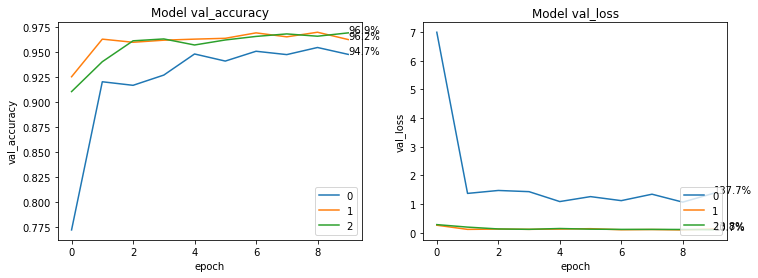

In [20]:
extra_layers_test()

### Size of the first layer

In [23]:
def first_layer_size_test():
    history = []
    params = {
        'fully_trainable': False,
        'retrain_last': True,
        'dropout': True,
        'number_of_layers': 1,
    }
    first_layer_size = [512, 256, 128, 64]

    for layer_size in first_layer_size:
        params.update(first_layer_size=layer_size)
        h = np.array(train_with_k_fold_cross_validation(folds, params))
        history.append(h)
    plot_model_comparison(history, first_layer_size, 'first_layer_size.png')

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               41746944  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                           

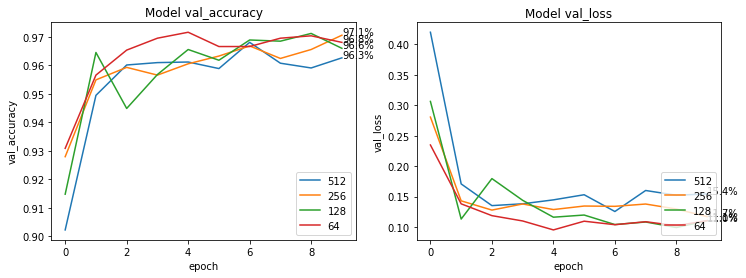

In [24]:
first_layer_size_test()

### Dropout

In [25]:
def dropout_test():
    history = []
    params = {
        'first_layer_size': 128,
        'fully_trainable': False,
        'retrain_last': True,
        'number_of_layers': 1,
    }
    dropout = [True, False]

    for option in dropout:
        params.update(dropout=option)
        h = np.array(train_with_k_fold_cross_validation(folds, params))
        history.append(h)
    plot_model_comparison(history, ['Dropout', 'Without'], 'dropout.png')

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_16 (Flatten)        (None, 81536)             0         
                                                                 
 batch_normalization_32 (Bat  (None, 81536)            326144    
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 128)               10436736  
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                          

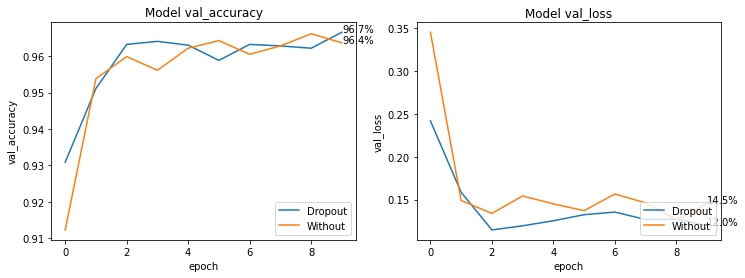

In [26]:
dropout_test()

### Retrain last layer

In [27]:
def retrain_last_layer_test():
    history = []
    params = {
        'first_layer_size': 128,
        'fully_trainable': False,
        'dropout': True,
        'number_of_layers': 1,
    }
    retrain_last = [True, False]

    for option in retrain_last:
        params.update(retrain_last=option)
        h = np.array(train_with_k_fold_cross_validation(folds, params))
        history.append(h)
    plot_model_comparison(history, ['Retrained', 'Frozen'], 'retrain_last_layer.png')

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_24 (Flatten)        (None, 81536)             0         
                                                                 
 batch_normalization_48 (Bat  (None, 81536)            326144    
 chNormalization)                                                
                                                                 
 dense_48 (Dense)            (None, 128)               10436736  
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                          

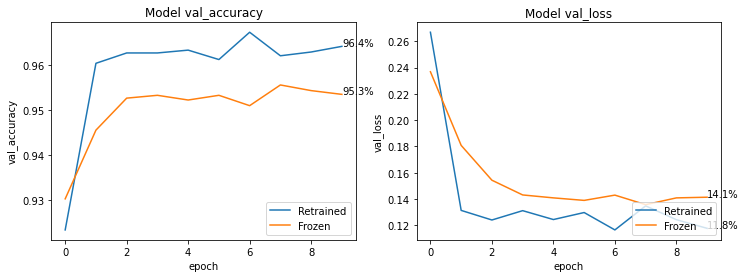

In [28]:
retrain_last_layer_test()

### Fully trained

In [19]:
def fully_trained_test():
    history = []
    params = {
        'first_layer_size': 128,
        'retrain_last': True,
        'dropout': True,
        'number_of_layers': 1,
    }
    fully_trainable = [True, False]

    for option in fully_trainable:
        params.update(fully_trainable=option)
        h = np.array(train_with_k_fold_cross_validation(folds, params))
        history.append(h)
    plot_model_comparison(history, ['Fully trained', 'Transfer learning'], 'fully_trained.png')

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               10436736  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                           

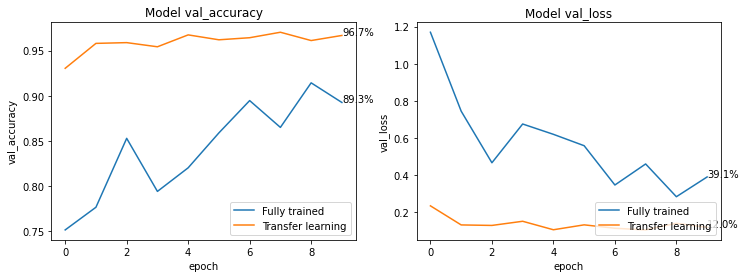

In [20]:
fully_trained_test()

## Validating failed cases and measure model performance

In [19]:
def validate_failed(model, X, y, show_image: bool):
    print('\nValidation process:')
    prob = model.predict(X, verbose=1)
    predictions = prob.argmax(axis=-1)
    expected_y = y.argmax(axis=-1)
    fails = 0
    for i in range(len(predictions)):
        if predictions[i] != expected_y[i]:
            fails += 1
            if show_image:
                hash_value = hashlib.sha1(X[i]).hexdigest()[:15]
                name = preprocessed_to_name[hash_value]
                original = cv2.imread(f'{dataset_folder}/{name}', cv2.IMREAD_ANYCOLOR)

                print(
                    f'\r{name} Expected {expected_y[i]} ({prob[i][expected_y[i]]}) but got {predictions[i]} ({prob[i][predictions[i]]})',
                    flush=True, end=' ' * 50)

                cv2.imshow('Preprocessed', X[i])
                cv2.imshow('Original', original)
                cv2.waitKey(0)
    print(f'Failed: {fails}')

    return classification_report(expected_y, predictions, digits=4)

### Final transfer learning model

In [20]:
def generate_final_model(seed: int, show_image: bool):
    final_params = {
        'first_layer_size': 128,
        'fully_trainable': False,
        'retrain_last': True,
        'dropout': True,
        'number_of_layers': 1,
    }

    X_train, X_val, y_train, y_val = train_test_split(x_full_p, y_full_p, test_size=0.2, random_state=seed)

    model, history = train_with_simple_holdout_validation(X_train, X_val, y_train, y_val, final_params)
    report = validate_failed(model, X_val, y_val, show_image)

    print('\nClassification report:')
    print(report)

    return model, history

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               10436736  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                           

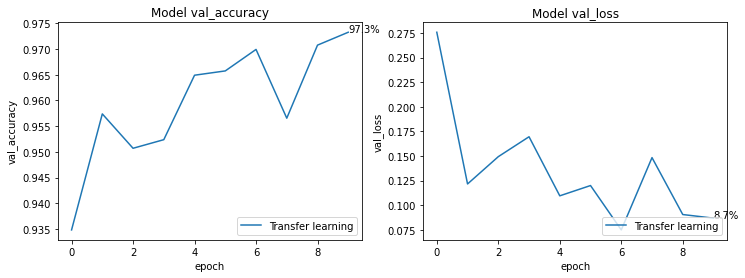

In [21]:
transfer_learning_model, transfer_learning_history = generate_final_model(random.randint(1, 1000), False)

# transfer_learning_model = keras.models.load_model('diagrams.h5')

plot_model_comparison([[transfer_learning_history]], ['Transfer learning'], 'transfer_learning_model.png')

### Generate fully trained model

In [22]:
def generate_fully_trained_model(seed: int, show_image: bool):
    final_params = {
        'first_layer_size': 128,
        'fully_trainable': True,
        'retrain_last': True,
        'dropout': True,
        'number_of_layers': 1,
    }

    X_train, X_val, y_train, y_val = train_test_split(x_full_p, y_full_p, test_size=0.2, random_state=seed)

    model, history = train_with_simple_holdout_validation(X_train, X_val, y_train, y_val, final_params)
    report = validate_failed(model, X_val, y_val, show_image)

    print('\nClassification report:')
    print(report)

    return model, history

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten_1 (Flatten)         (None, 81536)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 81536)            326144    
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               10436736  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                           

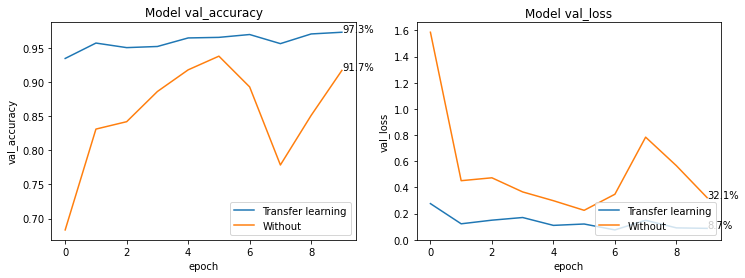

In [23]:
fully_trained_model, fully_trained_history = generate_fully_trained_model(random.randint(1, 1000), False)

plot_model_comparison([[transfer_learning_history],[fully_trained_history]], ['Transfer learning', 'Without'], 'transfer_learning_comparison.png')

## Fine-tuning

In [24]:
def fine_tuning(model, seed):
    model.trainable = True
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(1e-6),
                  metrics=['accuracy'])
    X_train, X_val, y_train, y_val = train_test_split(x_full_p, y_full_p, test_size=0.2, random_state=seed)
    model.summary()
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=2)
    report = validate_failed(model, X_val, y_val, False)

    print('\nClassification report:')
    print(report)

    return model, history

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               10436736  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

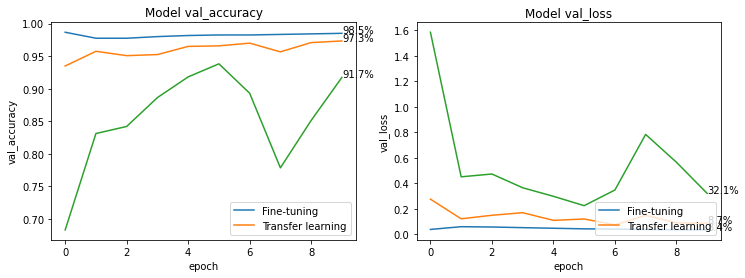

In [25]:
fine_tuned_model, fine_tuned_history = fine_tuning(transfer_learning_model, random.randint(1, 1000))

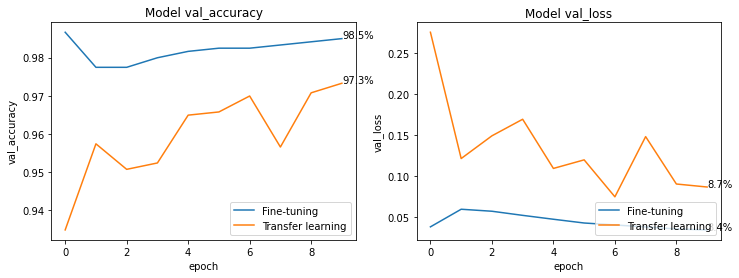

In [26]:
plot_model_comparison([[fine_tuned_history], [transfer_learning_history]], ['Fine-tuning', 'Transfer learning'], 'fine_tuning.png')

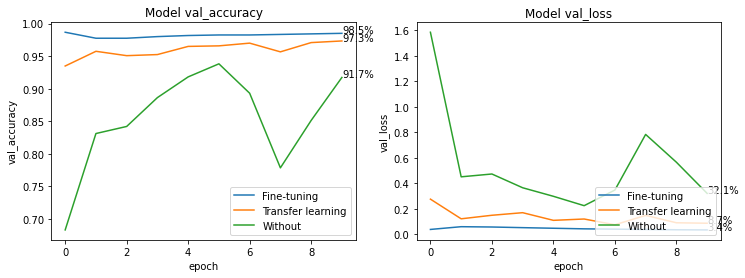

In [27]:
plot_model_comparison([[fine_tuned_history], [transfer_learning_history], [fully_trained_history]], ['Fine-tuning', 'Transfer learning', 'Without'], 'comparison.png')

## Testing new cases

In [ ]:
loaded_model = keras.models.load_model('diagrams.h5')

In [35]:
def show_and_predict_img(name: str, model):
    original = cv2.imread('test/' + name, cv2.IMREAD_ANYCOLOR)
    original = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)
    img = keras.utils.load_img(f'test/{name}', target_size=input_shape_densenet[:2])
    img = keras.utils.img_to_array(img)
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(original)
    title = plt.title(f'Original {name}')
    plt.setp(title, color='r')

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(x[0])
    title = plt.title(f'Preprocessed {name}')
    plt.setp(title, color='r')

    plt.show()

    prob = model.predict(x)
    prediction = prob.argmax(axis=-1)
    category = prediction[0]
    print(f"Prediction: {category} -> {class_map[category]}, prob {prob[0][category]:.3%}")

    return prob

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


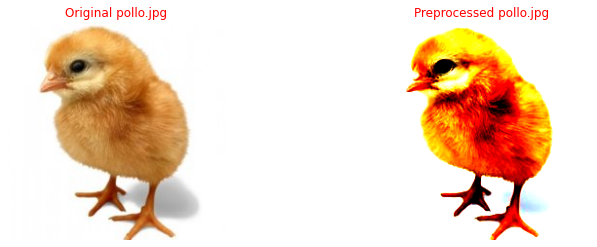

1/1 [==============================] - 0s 139ms/step
Prediction: 0 -> None, prop 99.552%


array([[9.9552047e-01, 1.0404197e-04, 2.0362512e-04, 3.5511504e-04,
        2.5778876e-03, 3.6807056e-04, 8.7073277e-04]], dtype=float32)

In [36]:
show_and_predict_img('pollo.jpg', fine_tuned_model)